In [ ]:
import os
import PIL.Image
import weave
import numpy as np
import PIL
import matplotlib.pyplot as plt

os.environ['WANDB_API_KEY'] = "bdc8857f9d6f7010cff35bcdc0ae9413e05c75e1"
weave.init('aghiles-kebaili/federated-pet') # 🐝

input_image = np.load('./data/13_16_33.npy')
input_image = input_image[input_image.shape[0] // 2]

input_image = input_image / input_image.max()
input_image = input_image + np.random.normal(0, 0.1, input_image.shape)

cmap = plt.get_cmap('hot')
input_image = cmap(input_image)
input_image = (input_image[:, :, :3] * 255).astype(np.uint8)
input_image = PIL.Image.fromarray(input_image)

@weave.op() # 🐝 Decorator to track requests
def testing_weave(input_image: PIL.Image) -> PIL.Image:
    # ... generating output image ...
    # outputing the generating image as PIL image
    output_image = input_image
    return output_image

testing_weave(input_image)


### Je check les valeurs SUV (max, min, moyenne)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from tqdm import tqdm

ROOT = '../datasets/EARL/Ano_Nifti/'

subjects = os.listdir(ROOT)[:100]
placeholder = np.zeros(shape=(subjects.__len__(), 3), dtype=np.float32)

for s, subject in tqdm(enumerate(subjects), position=0, leave=True, total=subjects.__len__()):
    subject_path = os.path.join(ROOT, subject)
    simgs = os.listdir(subject_path)

    for img_name in simgs:
        # filtering only PT images
        if not img_name.startswith('PT') or 'EARL' in img_name:
            continue

        img_path = os.path.join(subject_path, img_name)
        img_nii = nib.load(img_path).get_fdata()
        
        placeholder[s, 0] = img_nii.min()
        placeholder[s, 1] = img_nii.max()
        placeholder[s, 2] = img_nii.mean()
    
        
    


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [47]:
rand_indices = np.random.choice(subjects.__len__(), size=10, replace=False)
for idx in rand_indices:
    print(f"Subject: {subjects[idx]}, Min: {placeholder[idx, 0]}, Max: {placeholder[idx, 1]}, Mean: {placeholder[idx, 2]}")

Subject: 9401190790m, Min: 0.0, Max: 12.866623878479004, Mean: 0.023959901183843613
Subject: 9401189726m, Min: 0.0, Max: 24.14497947692871, Mean: 0.026275796815752983
Subject: 9401186744m, Min: 0.0, Max: 19.535802841186523, Mean: 0.0661429688334465
Subject: 9401170220m, Min: 0.0, Max: 4.9171833992004395, Mean: 0.03137609735131264
Subject: 9401167786m, Min: 0.0, Max: 14.460616111755371, Mean: 0.021418126299977303
Subject: 9401168770m, Min: 0.0, Max: 13.302177429199219, Mean: 0.027970507740974426
Subject: 9401154302m, Min: 0.0, Max: 4.757358074188232, Mean: 0.024020418524742126
Subject: 9401171676m, Min: 0.0, Max: 18.70843505859375, Mean: 0.03658916801214218
Subject: 9401164896m, Min: 0.0, Max: 5.504562854766846, Mean: 0.0263146311044693
Subject: 9401164485m, Min: 0.0, Max: 4.946689605712891, Mean: 0.0276942141354084


### Testing the MIP Dataset class

In [6]:
import torch
import numpy as np
from modules.data import MIPDataset

dataset = MIPDataset(
    root='./data/federated-pet/Ano_Nifti/', 
    pattern='PT_TEPTAPAC_Ano_MIP',
    random_crop_size=(128, 128),
    horizontal_flip=0.5,
    vertical_flip=0.5,
    dtype='float32'
)
dataset

In [7]:
for idx in range(dataset.__len__()):
    sample = dataset[idx]
    print(f"Sample {idx}: Image shape: {sample['image'].shape}, Dtype: {sample['image'].dtype}")

Sample 0: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 1: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 2: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 3: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 4: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 5: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 6: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 7: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 8: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 9: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 10: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 11: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 12: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 13: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sa

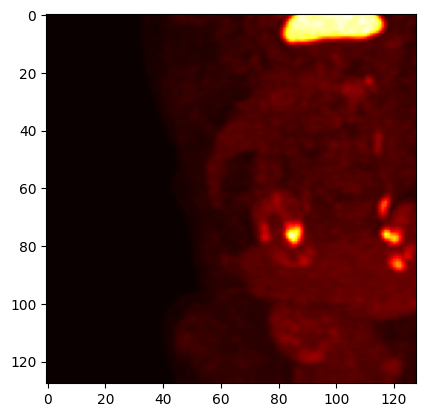

In [22]:
import matplotlib.pyplot as plt
plt.imshow(dataset[0]['image'].squeeze(), cmap='hot')

In [38]:
from modules.data import MIPDataModule
from modules.utils import set_seed

set_seed(43)

datamodule = MIPDataModule(
    root='./data/federated-pet/Ano_Nifti/', 
    pattern='PT_TEPTAPAC_Ano_MIP',
    train_ratio=0.9,
    batch_size=8,
    num_workers=4,
    random_crop_size=(128, 128)
)

datamodule.prepare_data()
datamodule.setup()

datamodule.train_dataset.paths

Seed set to 43


Seed set to 43 with deterministic=False
Discovered 19 MIP files under ./data/federated-pet/Ano_Nifti/ with pattern 'pt_teptapac_ano_mip'
  Training samples: 17
  Validation samples: 2


['./data/federated-pet/Ano_Nifti/9401154964m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154754m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154325m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154744m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154752m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154749m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154756m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154763m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154742m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154314m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154753m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154750m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154305m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/An

### Deleting MIP files

In [162]:
import os
from tqdm import tqdm

ROOT = '../datasets/EARL/Rennes_Nifti/'
subjects = os.listdir(ROOT)
for s, subject in tqdm(enumerate(subjects), position=0, leave=True, total=subjects.__len__()):
    subject_path = os.path.join(ROOT, subject)
    simgs = os.listdir(subject_path)

    for img_name in simgs:
        # deleting MIP images, files containing 'MIP' in their names
        if 'MIP' in img_name:
            img_path = os.path.join(subject_path, img_name)
            os.remove(img_path)

100%|██████████| 77/77 [00:00<00:00, 13631.09it/s]


### Testing the VAE

In [163]:
from modules.models.autoencoders import VariationalAutoencoder
from omegaconf import OmegaConf
import torch

config = OmegaConf.load('configs/reconstruct_model.yaml')
config = OmegaConf.to_container(config, resolve=True)

model = VariationalAutoencoder.load_from_checkpoint('./runs/patch-reconstruction-model/2025_11_19_184745/last.ckpt')
model = model.eval()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work_p11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work_p11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [186]:
from modules.data import MIPDataset, MIPDataModule
from omegaconf import OmegaConf

config = OmegaConf.load('configs/reconstruct_model.yaml')
config = OmegaConf.to_container(config, resolve=True)

config['datamodule']['root'] = '../datasets/EARL/Rennes_Nifti/'
config['datamodule']['pattern'] = '_AC_MIP'
config['datamodule']['train_ratio'] = 0.02  # Use all data for validation/testing

datamodule = MIPDataModule(**config['datamodule'])
datamodule.prepare_data()
datamodule.setup()

val_paths = datamodule.val_dataset.paths

validation_dataset = MIPDataset(
    paths=val_paths,
    cache_after_load=True,
    normalize=True,
    dtype='float32'
)

Discovered 77 MIP files under ../datasets/EARL/Rennes_Nifti/ with pattern '_ac_mip'
  Training samples: 1
  Validation samples: 76


MIP Image metadata: (torch.Size([1, 1, 463, 200]), 1.0910530090332031, 2.357696533203125)


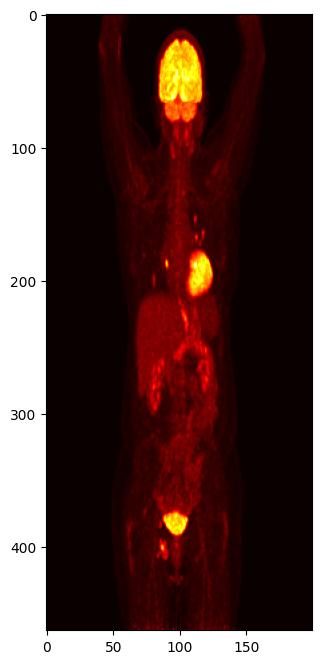

In [199]:
sample = validation_dataset[np.random.randint(validation_dataset.__len__())]
random_mip_image = sample['image'].unsqueeze(0).to(model.device)
mean, std = sample['mean'], sample['std']
print('MIP Image metadata: {}'.format((random_mip_image.shape, mean, std)))

plt.figure(figsize=(2 * int(random_mip_image.shape[-2] // 100), 4 * int(random_mip_image.shape[-1] // 100)))
plt.imshow(random_mip_image.squeeze().cpu(), cmap='hot')
plt.show()

In [200]:
import numpy as np
import torch
from tqdm import tqdm

stride = 2
patch_size: int = 128
_, _, H, W = random_mip_image.shape

# compute steps and padded sizes
x_steps = (max(0, W - patch_size)) // stride + 1
y_steps = (max(0, H - patch_size)) // stride + 1
padded_w = stride * (x_steps - 1) + patch_size
padded_h = stride * (y_steps - 1) + patch_size
pad_w = padded_w - W
pad_h = padded_h - H

padded_true_mip = random_mip_image
if pad_h > 0 or pad_w > 0:
    padded_true_mip = np.pad(random_mip_image, ((0, pad_h),(0, pad_w)), mode='constant', constant_values=0.0)

# prepare accumulators
accum = torch.zeros_like(padded_true_mip, dtype=torch.float64)
counts = torch.zeros_like(padded_true_mip, dtype=torch.float32)

# build counts matrix as in your example
for xi in range(x_steps):
    for yi in range(y_steps):
        x_start = xi * stride
        y_start = yi * stride
        counts[:, :, y_start: y_start + patch_size, x_start: x_start + patch_size] += 1.0

# sliding inference
for xi in tqdm(range(x_steps), position=0, leave=True):
    for yi in range(y_steps):
        x_start = xi * stride
        y_start = yi * stride
        true_patch = padded_true_mip[:, :, y_start: y_start + patch_size, x_start: x_start + patch_size]

        with torch.no_grad():
            pred_patch = model.forward(true_patch)
        
        accum[:, :, y_start: y_start + patch_size, x_start: x_start + patch_size] += pred_patch

# average
counts[counts == 0] = 1.0
recon_norm = accum / counts
recon_norm = recon_norm[:, :, :H, :W]

true = random_mip_image[:, :, :H, :W] * std + mean
recon = recon_norm * std + mean

print(true.shape, recon.shape)

100%|██████████| 37/37 [00:34<00:00,  1.08it/s]

torch.Size([1, 1, 463, 200]) torch.Size([1, 1, 463, 200])


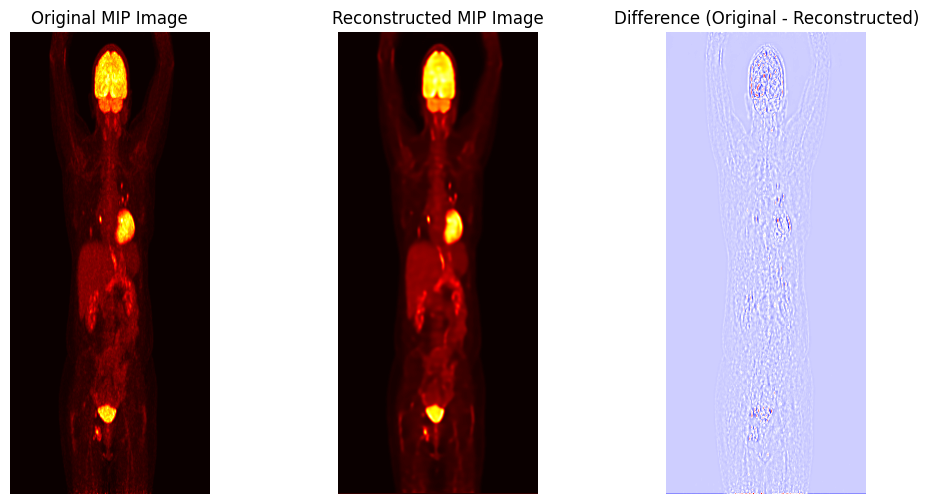

In [201]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original MIP Image')
plt.imshow(true.squeeze().cpu().numpy(), cmap='hot')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Reconstructed MIP Image')
plt.imshow(recon.squeeze().cpu().numpy(), cmap='hot')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Difference (Original - Reconstructed)')
plt.imshow((true - recon).squeeze().cpu().numpy(), cmap='bwr')
plt.axis('off')
plt.show()


In [197]:
true.min(), true.max(), recon.min(), recon.max()

(tensor(0., device='cuda:0'),
 tensor(32.2288, device='cuda:0'),
 tensor(-0.1026, device='cuda:0', dtype=torch.float64),
 tensor(27.3042, device='cuda:0', dtype=torch.float64))

### ANO Metadata (Constructor, Versions, Protocols)

In [145]:
import os
import pandas as pd
from tqdm import tqdm

ROOT = '../datasets/EARL/Ano_metadata/'
metadata_files = os.listdir(ROOT)

tags = [
    'ProtocolName', 'BodyPartExamined', 'Manufacturer',
    'ManufacturerModelName', 'SoftwareVersions'
]

metadata_dict = {tag: [] for tag in tags}
for s_metadata in tqdm(os.listdir(ROOT), position=0, leave=True):
    path = os.path.join(ROOT, s_metadata)
    df = pd.read_csv(path)

    for tag in tags:
        if tag in df.columns:
            value = df[tag].iloc[0]
            metadata_dict[tag].append(value if not pd.isna(value) else 'N/A')

# display unique values given the different tags
for tag in tags:
    unique_values = set(metadata_dict[tag])
    print(f"{tag} unique values: {unique_values}")

100%|██████████| 946/946 [00:01<00:00, 490.73it/s]

ProtocolName unique values: {'N/A'}
BodyPartExamined unique values: {'TEP FDG', 'MN101 TEP FLUORO', 'MN121 TEP2  FDG', 'MN132 TEP4 FLUOR', 'MN108 TEP2 FLUDE'}
Manufacturer unique values: {'GE MEDICAL SYSTEMS'}
ManufacturerModelName unique values: {'Discovery 710'}
SoftwareVersions unique values: {'53.00', 'pet_mfk.56'}


### Diplaying first order radiomics

In [148]:
import pandas as pd

radiomics = [
    'min', 'max', 'mean', 'std',
    'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum'
]

df = pd.read_csv('../datasets/EARL/Ano_radiomics/mip_radiomics.csv')
df

,image_path,min,max,mean,std,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,subject,file,path
0,../datasets/EARL/Ano_Nifti/9401152847m/PT_TEPT...,0.0,9.698443,0.230278,0.517092,0.230278,0.0,9.698443,76007.0,4.0,9401152847m,PT_TEPTAPAC_Ano_MIP.nii.gz,../datasets/EARL/Ano_Nifti/9401152847m/PT_TEPT...
1,../datasets/EARL/Ano_Nifti/9401152847m/PT_TEPT...,0.0,7.518912,0.178511,0.402542,0.178511,0.0,7.518912,75930.0,6.0,9401152847m,PT_TEPTAPRECONEARL_Ano_MIP.nii.gz,../datasets/EARL/Ano_Nifti/9401152847m/PT_TEPT...
2,../datasets/EARL/Ano_Nifti/9401152849m/PT_TEPT...,0.0,17.759044,0.347150,0.771847,0.347150,0.0,17.759044,66788.0,2.0,9401152849m,PT_TEPTAPAC_Ano_MIP.nii.gz,../datasets/EARL/Ano_Nifti/9401152849m/PT_TEPT...
3,../datasets/EARL/Ano_Nifti/9401152849m/PT_TEPT...,0.0,13.501012,0.256735,0.578018,0.256735,0.0,13.501012,66740.0,4.0,9401152849m,PT_TEPTAPRECONEARL_Ano_MIP.nii.gz,../datasets/EARL/Ano_Nifti/9401152849m/PT_TEPT...
4,../datasets/EARL/Ano_Nifti/9401152852m/PT_TEPT...,0.0,7.478776,0.180747,0.430089,0.180747,0.0,7.478776,66930.0,3.0,9401152852m,PT_TEPTAPAC_Ano_MIP.nii.gz,../datasets/EARL/Ano_Nifti/9401152852m/PT_TEPT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,../datasets/EARL/Ano_Nifti/9401190129m/PT_TEPT...,0.0,6.953323,0.197398,0.468000,0.197398,0.0,6.953323,76035.0,3.0,9401190129m,PT_TEPTAPRECONEARL_Ano_MIP.nii.gz,../datasets/EARL/Ano_Nifti/9401190129m/PT_TEPT...
1882,../datasets/EARL/Ano_Nifti/9401190131m/PT_TEPT...,0.0,61.076918,0.414973,1.675142,0.414973,0.0,61.076918,66743.0,7.0,9401190131m,PT_TEPTAPAC_Ano_MIP.nii.gz,../datasets/EARL/Ano_Nifti/9401190131m/PT_TEPT...
1883,../datasets/EARL/Ano_Nifti/9401190131m/PT_TEPT...,0.0,43.398251,0.317890,1.236191,0.317890,0.0,43.398251,66743.0,8.0,9401190131m,PT_TEPTAPRECONEARL_Ano_MIP.nii.gz,../datasets/EARL/Ano_Nifti/9401190131m/PT_TEPT...
1884,../datasets/EARL/Ano_Nifti/9401190790m/PT_TEPT...,0.0,12.866624,0.225078,0.618601,0.225078,0.0,12.866624,57100.0,9.0,9401190790m,PT_TEPTAPAC_Ano_MIP.nii.gz,../datasets/EARL/Ano_Nifti/9401190790m/PT_TEPT...
